<a href="https://colab.research.google.com/github/Sathwik-parimi-07/woc/blob/main/Multiclass_preddiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv(r'/content/drive/MyDrive/woc drive/nn_train.csv')

In [ ]:
data.info()
data.head() #all features in numerical values, no categorical data to encode

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 1027 entries, ID to class_label
dtypes: int64(1027)
memory usage: 626.8 MB


,ID,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_1017,Feature_1018,Feature_1019,Feature_1020,Feature_1021,Feature_1022,Feature_1023,Feature_1024,binary_label,class_label
0,1,81,109,91,96,107,97,103,95,100,...,114,93,91,98,72,92,78,78,0,5
1,2,168,168,169,169,170,171,172,172,175,...,44,44,44,44,44,44,44,44,0,9
2,3,14,20,32,6,27,6,5,34,15,...,63,64,63,60,54,48,43,41,0,5
3,4,60,109,157,126,82,80,70,58,37,...,105,102,99,98,100,105,111,114,1,8
4,5,63,72,86,75,93,77,75,67,62,...,108,109,102,106,96,91,102,89,0,5


In [ ]:
data2=data.drop(['ID','binary_label'],axis=1) #ID is of no use and first task is only limited to binary  classification
data2.isnull().sum().unique() #all are non null values

array([0])

In [ ]:
x =data2.iloc[:8000,:-1].values    # and first task is only limited to binary  classification
y=data2.iloc[:8000,-1].values

In [ ]:
#standardisation
#normalisation features
mean=np.mean(x,axis=0)
sd=np.std(x,axis=0)
x=(x-mean)/sd

print(x)

[[-0.49353373 -0.09914044 -0.38396936 ... -0.33494566 -0.56147072
  -0.5439826 ]
 [ 0.76467384  0.76661878  0.7652921  ... -1.16633957 -1.14662066
  -1.12196411]
 [-1.46249818 -1.4051162  -1.25328252 ... -1.09705674 -1.16383095
  -1.17296248]
 ...
 [-0.27660139 -0.31924871 -0.36923524 ...  0.3405619   0.40230564
   0.35698858]
 [ 0.62005228  0.61987993  0.60321677 ...  1.48372852  1.34887171
   1.25795976]
 [-0.85508763 -0.83283469 -0.60498118 ... -0.7160012  -0.80241481
  -0.84997281]]


In [ ]:
# Check if any NaN or Inf values are in x
print(np.isnan(x).sum())  # Count NaNs
print(np.isinf(x).sum())  # Count Infs

0
0


In [ ]:
# One-hot encode y for multi-class classification (use 10 classes for 1 to 10)
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y - 1]  # y should be an array of integer labels (1-indexed)

# Find the number of unique classes (multi-class: 10 classes)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")

# Display all unique classes
unique_classes = np.unique(y)
print(f"Unique classes: {unique_classes}")

Number of classes: 10
Unique classes: [ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
# One-hot encode labels for multi-class classification
y_one_hot = one_hot_encode(y, num_classes)
print(y_one_hot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
# Transpose X and y for easier matrix operations
X = x.T  # Shape (features, samples)
Y = y_one_hot.T  # Shape (classes, samples)


In [ ]:
nan_mask = np.isnan(x)
if np.any(nan_mask):
    print("NaN values found in x at positions:", np.where(nan_mask))


# Check for Inf values
inf_mask = np.isinf(x)
if np.any(inf_mask):
    print("Inf values found in x at positions:", np.where(inf_mask))

In [ ]:
print(f"{x.shape} , {y.shape}")

(8000, 1024) , (8000,)


In [ ]:
# Sigmoid activation function for hidden layers
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# ReLU activation function for hidden layers
def relu(z):
    return np.maximum(0, z)

In [ ]:
def sigmoid_derivative(A):
    return A * (1 - A)

def relu_derivative(z):
    return (z > 0).astype(int)

In [ ]:
# Softmax activation function for the output layer (multi-class)
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))  # Stability improvement
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

In [ ]:
def random_parameters(layers):
    parameters = {}
    for i in range(1, len(layers)):
        # He initialization for ReLU
        parameters[f"w{i}"] = np.random.randn(layers[i], layers[i-1]) * np.sqrt(2. / layers[i-1])
        parameters[f"b{i}"] = np.zeros((layers[i], 1))
    return parameters


In [ ]:
# Forward propagation
def forward(x, parameters, layers):
    cache = {"A0": x}
    for i in range(1, len(layers)):
        w = parameters[f"w{i}"]
        b = parameters[f"b{i}"]
        A_prev = cache[f"A{i-1}"]
        z = np.dot(w, A_prev) + b  # Linear transformation
        # Apply ReLU for hidden layers, Softmax for the output layer (multi-class)
        A = relu(z) if i < len(layers) - 1 else softmax(z)  # Use softmax for multi-class output
        cache[f"z{i}"] = z
        cache[f"A{i}"] = A
    return cache



In [ ]:
# Backward propagation
def backward(x, y, parameters, cache, layers):
    grads = {}
    m = x.shape[1]
    A_final = cache[f"A{len(layers)-1}"]

    # Compute dA for the output layer (categorical cross-entropy derivative)
    dA = A_final - y  # Derivative of softmax + cross-entropy

    for i in reversed(range(1, len(layers))):
        A_prev = cache[f"A{i-1}"]
        z = cache[f"z{i}"]

        # Output layer (softmax for multi-class classification)
        if i == len(layers) - 1:
            dz = dA  # No need to apply softmax derivative separately

        # Hidden layers (ReLU)
        else:
            dz = dA * (z > 0).astype(int)  # ReLU derivative

        # Compute gradients for weights and biases
        grads[f"dw{i}"] = np.dot(dz, A_prev.T) / m
        grads[f"db{i}"] = np.sum(dz, axis=1, keepdims=True) / m

        # Backpropagate the error to the previous layer
        dA = np.dot(parameters[f"w{i}"].T, dz)

    return grads


In [ ]:
# Prediction function
def predict(X, parameters, layers):
    cache = forward(X, parameters, layers)
    A_final = cache[f"A{len(layers)-1}"]
    predictions = np.argmax(A_final, axis=0)  # Get the index of the max probability for each sample
    return predictions


In [ ]:
# Train the neural network
def train_neural_network(X, y, layers, epochs, learning_rate):
    parameters = random_parameters(layers)
    losses = []

    for epoch in range(epochs):
        # Forward pass
        cache = forward(X, parameters, layers)

        # Backward pass
        grads = backward(X, y, parameters, cache, layers)

        # Update parameters using gradient descent
        for i in range(1, len(layers)):
            parameters[f"w{i}"] -= learning_rate * grads[f"dw{i}"]
            parameters[f"b{i}"] -= learning_rate * grads[f"db{i}"]

        # Calculate categorical cross-entropy loss
        A_final = cache[f"A{len(layers)-1}"]
        loss = -np.mean(np.sum(y * np.log(A_final + 1e-9), axis=0))  # Categorical cross-entropy loss
        losses.append(loss)

        # Print the loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return parameters, losses



In [ ]:
# Set the layers and other hyperparameters
layers = [X.shape[0],  10, num_classes]  # Example: 64 units in the first hidden layer, 32 in the second, 10 classes in the output layer

# Train the neural network
parameters, losses = train_neural_network(X, Y, layers, epochs=5000, learning_rate=0.0001)

# Print final loss
print(f"Final Loss after 1000 epochs: {losses[-1]:.4f}")


Epoch 0, Loss: 2.7685
Epoch 100, Loss: 2.6952
Epoch 200, Loss: 2.6457
Epoch 300, Loss: 2.6106
Epoch 400, Loss: 2.5838
Epoch 500, Loss: 2.5619
Epoch 600, Loss: 2.5434
Epoch 700, Loss: 2.5272
Epoch 800, Loss: 2.5128
Epoch 900, Loss: 2.4996
Epoch 1000, Loss: 2.4875
Epoch 1100, Loss: 2.4763
Epoch 1200, Loss: 2.4658
Epoch 1300, Loss: 2.4561
Epoch 1400, Loss: 2.4470
Epoch 1500, Loss: 2.4384
Epoch 1600, Loss: 2.4302
Epoch 1700, Loss: 2.4224
Epoch 1800, Loss: 2.4150
Epoch 1900, Loss: 2.4080
Epoch 2000, Loss: 2.4013
Epoch 2100, Loss: 2.3948
Epoch 2200, Loss: 2.3887
Epoch 2300, Loss: 2.3829
Epoch 2400, Loss: 2.3772
Epoch 2500, Loss: 2.3719
Epoch 2600, Loss: 2.3667
Epoch 2700, Loss: 2.3617
Epoch 2800, Loss: 2.3569
Epoch 2900, Loss: 2.3522
Epoch 3000, Loss: 2.3477
Epoch 3100, Loss: 2.3434
Epoch 3200, Loss: 2.3391
Epoch 3300, Loss: 2.3351
Epoch 3400, Loss: 2.3311
Epoch 3500, Loss: 2.3274
Epoch 3600, Loss: 2.3237
Epoch 3700, Loss: 2.3201
Epoch 3800, Loss: 2.3166
Epoch 3900, Loss: 2.3132
Epoch 4000, 

In [ ]:
y_pred = predict(X, parameters, layers)
y_true = np.argmax(y_one_hot.T, axis=0)  # Should result in a 1D array of shape (num_samples,)
print(y_true.shape)
print(y.shape)

(8000,)
(8000,)


In [ ]:
print(y_pred[:10])
print(y_true[:10])

[9 6 4 4 4 9 4 9 2 2]
[4 8 4 7 4 9 8 7 7 2]


In [ ]:
import numpy as np

def f1_score(y_true, y_pred):

    # Convert predicted probabilities to class labels (argmax)
    y_pred_labels = np.argmax(y_pred, axis=0)
    y_true_labels = np.argmax(y_true, axis=0)

    # Calculate true positives, false positives, and false negatives
    tp = np.sum((y_true_labels == 1) & (y_pred_labels == 1))
    fp = np.sum((y_true_labels == 0) & (y_pred_labels == 1))
    fn = np.sum((y_true_labels == 1) & (y_pred_labels == 0))

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1, precision, recall


In [ ]:
f1, precision, recall = f1_score(y_true, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000


In [ ]:
y_pred = predict(X, parameters, layers)  # Predictions from the model
y_pred_labels = np.argmax(y_pred, axis=0)  # Convert to class labels
print("Unique predictions:", np.unique(y_pred_labels))  # Should show a variety of classes, not just one


Unique predictions: [23]


In [ ]:
x.shape

(8000, 1024)

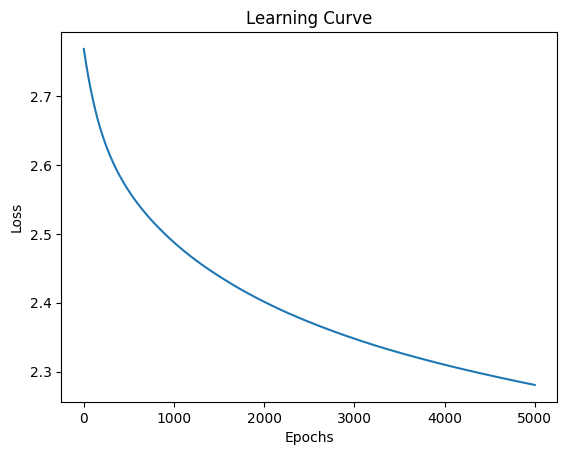

In [ ]:
# Plot the learning curve (loss vs epochs)
plt.plot(losses)
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [ ]:
import numpy as np

def evaluate_metrics(y_true, y_pred, num_classes):
    def precision(y_true, y_pred, num_classes):
        precision_scores = []
        for i in range(num_classes):
            true_positive = np.sum((y_pred == i) & (y_true == i))
            false_positive = np.sum((y_pred == i) & (y_true != i))
            precision_scores.append(true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0)
        return np.mean(precision_scores)

    def recall(y_true, y_pred, num_classes):
        recall_scores = []
        for i in range(num_classes):
            true_positive = np.sum((y_pred == i) & (y_true == i))
            false_negative = np.sum((y_pred != i) & (y_true == i))
            recall_scores.append(true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0)
        return np.mean(recall_scores)

    def f1_score(y_true, y_pred, num_classes):
        precision_val = precision(y_true, y_pred, num_classes)
        recall_val = recall(y_true, y_pred, num_classes)
        return 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0

    # Calculate metrics
    precision_val = precision(y_true, y_pred, num_classes)
    recall_val = recall(y_true, y_pred, num_classes)
    f1_val = f1_score(y_true, y_pred, num_classes)

    return precision_val, recall_val, f1_val

# Assuming y_true and y_pred are the true labels and predictions
y_true = np.argmax(y.T, axis=0)  # Convert one-hot encoded y to label format (0 to num_classes-1)
y_pred = predict(X, parameters, layers)  # Your prediction function

# Number of classes
num_classes = len(np.unique(y))

# Evaluate metrics
precision_val, recall_val, f1_val = evaluate_metrics(y_true, y_pred, num_classes)

# Print the metrics
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")
